In [1]:

import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('../data/food-101/images')


In [4]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=8, bs=64).normalize(imagenet_stats)


In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

Initialize Rest¶


In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained=True)


/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19962525.34it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


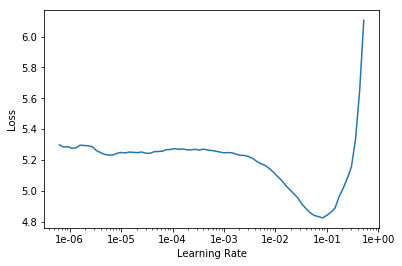

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
lr = 1e-2


In [10]:
learn.fit_one_cycle(8 , lr)


epoch,train_loss,valid_loss,error_rate,time
0,2.058605,1.689986,0.434109,16:30
1,2.024915,1.863820,0.475495,14:39


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceba

KeyboardInterrupt: 

In [11]:
model_name="resnet34"


In [12]:
learn.save(f'{model_name}-stage-1')


In [13]:
learn.load(f'{model_name}-stage-1')


Learner(data=ImageDataBunch;

Train: LabelList (80800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
clam_chowder,clam_chowder,clam_chowder,clam_chowder,clam_chowder
Path: ../data/food-101/images;

Valid: LabelList (20200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
carrot_cake,tacos,baby_back_ribs,clam_chowder,mussels
Path: ../data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [ ]:
learn.unfreeze()


In [ ]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)


In [ ]:
learn.recorder.plot(skip_end=10)


In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-4))


In [ ]:
learn.save(f'{model_name}-stage-2')


In [ ]:
learn.load(f'{model_name}-stage-2');


# Interpretation

In [ ]:
learn.load(f'{model_name}-stage-2');
